In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tpot import TPOTClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold

C:\Users\Olek\anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
#checking ticket type
train['Ticket_type'] = train['Ticket'].apply(lambda x: x[0:3])
train['Ticket_type'] = train['Ticket_type'].astype('category')
train['Ticket_type'] = train['Ticket_type'].cat.codes

test['Ticket_type'] = test['Ticket'].apply(lambda x: x[0:3])
test['Ticket_type'] = test['Ticket_type'].astype('category')
test['Ticket_type'] = test['Ticket_type'].cat.codes

In [5]:
train['Ticket_type'].value_counts()

137    60
83     53
81     48
3      47
130    28
       ..
68      1
29      1
28      1
26      1
80      1
Name: Ticket_type, Length: 154, dtype: int64

In [6]:
#Testing if passenger had a cabin
train['Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

In [7]:
full_data = [train, test]
for ds in full_data:
    #creating new feature Family_size as a combination of siblings, spouses, parents and kids on board
    ds['Family_size'] = ds['SibSp'] + ds['Parch'] + 1 
    #checking if anybody was travelling alone
    ds['IsAlone'] = 0
    ds.loc[ds['Family_size']==1, 'IsAlone'] = 1
    #removing nulls from Embarked and Fare cols
    ds['Embarked'] = ds['Embarked'].fillna('S')
    ds['Fare'] = ds['Fare'].fillna(ds['Fare'].median())

#creating categorical fare column
train['Cat_Fare'] = pd.qcut(train['Fare'], 4)

#creating categorical age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['Cat_Age'] = pd.cut(train['Age'], 5)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    # Group all non-common titles into one single grouping "Rare"
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    

C:\Users\Olek\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['Cat_Age', 'Cat_Fare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [9]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Ticket_type,Family_size,IsAlone,Title
0,0,3,1,1,0,0,0,124,2,0,1
1,1,1,0,2,0,3,1,137,2,0,3
2,1,3,0,1,0,1,0,148,1,1,2
3,1,1,0,2,0,3,0,3,2,0,3
4,0,3,1,2,0,1,0,97,1,1,1


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

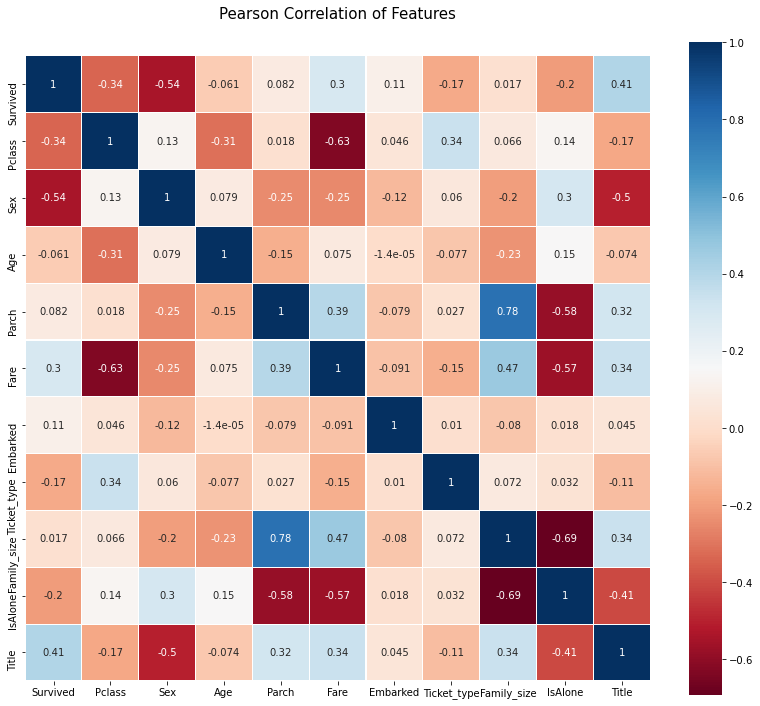

In [10]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [11]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)

In [12]:
!pip install --upgrade --user pip

In [13]:
cv = KFold(n_splits=10, random_state=111)
model = TPOTClassifier(generations=20, population_size=40, cv=cv, scoring='accuracy', verbosity=2)

C:\Users\Olek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [14]:
model.fit(train, y_train)

Optimization Progress:   0%|          | 0/840 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.836154806491885

Generation 2 - Current best internal CV score: 0.836154806491885

Generation 3 - Current best internal CV score: 0.836154806491885

Generation 4 - Current best internal CV score: 0.8395880149812734

Generation 5 - Current best internal CV score: 0.8395880149812734

Generation 6 - Current best internal CV score: 0.845143570536829

Generation 7 - Current best internal CV score: 0.8462671660424469

Generation 8 - Current best internal CV score: 0.8462671660424469

Generation 9 - Current best internal CV score: 0.8462671660424469

Generation 10 - Current best internal CV score: 0.849612983770287

Generation 11 - Current best internal CV score: 0.8518851435705368

Generation 12 - Current best internal CV score: 0.8518851435705368

Generation 13 - Current best internal CV score: 0.8541198501872659

Generation 14 - Current best internal CV score: 0.8541198501872659

Generation 15 - Current best internal CV score: 0.85411985018

TPOTClassifier(cv=KFold(n_splits=10, random_state=111, shuffle=False),
               generations=20, population_size=40, scoring='accuracy',
               verbosity=2)

In [15]:
cv2 = KFold(n_splits=5, random_state=111)
model2 = TPOTClassifier(generations=20, population_size=100, cv=cv2, scoring='accuracy', verbosity=2)
model2.fit(train, y_train)

C:\Users\Olek\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Optimization Progress:   0%|          | 0/2100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8395016006528152

Generation 2 - Current best internal CV score: 0.8395016006528152

Generation 3 - Current best internal CV score: 0.8440085368150149

Generation 4 - Current best internal CV score: 0.8440085368150149

Generation 5 - Current best internal CV score: 0.8440148138848785

Generation 6 - Current best internal CV score: 0.8440148138848785

Generation 7 - Current best internal CV score: 0.8473856004017325

Generation 8 - Current best internal CV score: 0.848496641767623

Generation 9 - Current best internal CV score: 0.848496641767623

Generation 10 - Current best internal CV score: 0.848496641767623

Generation 11 - Current best internal CV score: 0.8529847467202311

Generation 12 - Current best internal CV score: 0.8574602975331116

Generation 13 - Current best internal CV score: 0.8574602975331116

Generation 14 - Current best internal CV score: 0.8574602975331116

Generation 15 - Current best internal CV score: 0.857460297

TPOTClassifier(cv=KFold(n_splits=5, random_state=111, shuffle=False),
               generations=20, scoring='accuracy', verbosity=2)

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [23]:
lr_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
           'tol': [1e-4, 1e-3, 1e-2],
           'C': [0.1, 0.3, 0.6, 0.8, 1, 1.5, 2],
           'fit_intercept': [True, False],
           'class_weight': [None, 'balanced'],
           'max_iter': [50, 100, 200, 400, 500],
           'random_state': [111],
           'n_jobs': [-1]}
lr_rscv = RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=lr_grid, n_iter=100, scoring='accuracy', n_jobs=-1, cv=5, random_state=111, verbose=2).fit(train, y_train)
print(lr_rscv.best_estimator_)
print(lr_rscv.best_params_)
print(lr_rscv.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


LogisticRegression(C=0.8, max_iter=50, n_jobs=-1, random_state=111)
{'tol': 0.0001, 'random_state': 111, 'penalty': 'l2', 'n_jobs': -1, 'max_iter': 50, 'fit_intercept': True, 'class_weight': None, 'C': 0.8}
0.8092021844203126


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn_grid = {'n_neighbors': [2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 17, 20],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [10, 20, 30, 40, 50],
            'p': [1,2],
            'n_jobs': [-1]}
knn_rscv = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions=knn_grid, n_iter=100, scoring='accuracy', n_jobs=-1, cv=5, random_state=111, verbose=2).fit(train, y_train)
print(knn_rscv.best_estimator_)
print(knn_rscv.best_params_)
print(knn_rscv.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:    4.3s


KNeighborsClassifier(algorithm='ball_tree', leaf_size=40, n_jobs=-1, p=1,
                     weights='distance')
{'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'n_jobs': -1, 'leaf_size': 40, 'algorithm': 'ball_tree'}
0.8069612704789405


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.5s finished


In [27]:
from sklearn.svm import SVC
svc_grid = {'C': [0.1, 0.3, 0.6, 0.8, 1, 1.5, 2, 5, 10],
             'gamma': [0.1,0.01, 'auto', 'scale'],
             'kernel': ['rbf', 'sigmoid'],
             'tol': [1e-4, 1e-3, 1e-2],
             'class_weight': [None, 'balanced'],
             'max_iter': [-1],
             'decision_function_shape': ['ovo', 'ovr'],
             'random_state': [111]}
svc_rscv = RandomizedSearchCV(estimator=SVC(), param_distributions=svc_grid, n_iter=100, scoring='accuracy', n_jobs=-1, cv=5, random_state=111, verbose=2).fit(train, y_train)
print(svc_rscv.best_estimator_)
print(svc_rscv.best_params_)
print(svc_rscv.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


SVC(C=1.5, gamma=0.1, random_state=111, tol=0.01)
{'tol': 0.01, 'random_state': 111, 'max_iter': -1, 'kernel': 'rbf', 'gamma': 0.1, 'decision_function_shape': 'ovr', 'class_weight': None, 'C': 1.5}
0.827185989580064


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


In [29]:
from sklearn.tree import DecisionTreeClassifier
dt_grid = {'max_depth': [1, 2, 3, 4,5],
           'max_features': ['auto', 'sqrt', 'log2', None],
           'min_samples_split': [1, 2, 4, 6, 8, 10, 12, 16, 20, 24],
           'criterion': ['gini', 'entropy'],
           'splitter': ['random', 'best'],
           'random_state': [111]}
dt_rscv = RandomizedSearchCV(estimator=DecisionTreeClassifier(), param_distributions=dt_grid, n_iter=100, scoring='accuracy', n_jobs=-1, cv=5, random_state=111, verbose=2).fit(train, y_train)
print(dt_rscv.best_estimator_)
print(dt_rscv.best_params_)
print(dt_rscv.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=12,
                       random_state=111)
{'splitter': 'best', 'random_state': 111, 'min_samples_split': 12, 'max_features': None, 'max_depth': 4, 'criterion': 'entropy'}
0.8260121775155357


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


In [31]:
rf_grid = {'bootstrap': [True, False],
            'max_depth': [1, 2, 3, 4, 5, 6,7, 8, 9,10, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
            'criterion': ['gini', 'entropy'],
            'n_jobs': [-1],
            'random_state': [111],
            'class_weight': [None, 'balanced', 'balanced_subsample']}
rf_rscv = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_grid, n_iter=100, scoring='accuracy', n_jobs=-1, cv=5, random_state=111, verbose=2).fit(train, y_train)
print(rf_rscv.best_estimator_)
print(rf_rscv.best_params_)
print(rf_rscv.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=7, min_samples_leaf=4, n_estimators=1400,
                       n_jobs=-1, random_state=111)
{'random_state': 111, 'n_jobs': -1, 'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': False}
0.8395141547925429


In [33]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB

clf1_lr = LogisticRegression(tol=0.0001, random_state=111, penalty='l2', n_jobs=-1, max_iter=50, fit_intercept=True, class_weight=None, C=0.8)
clf2_knn = KNeighborsClassifier(weights='distance', p=1, n_neighbors=5, n_jobs=-1, leaf_size=40, algorithm='ball_tree')
clf3_svc = SVC(C=1.5, gamma=0.1, random_state=111, tol=0.01)
clf4_gnb = GaussianNB()
clf5_dt = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=12, random_state=111)
clf6_rf = RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample', max_depth=7, min_samples_leaf=4, n_estimators=1400, n_jobs=-1, random_state=111)
clf7_xgb = xgb.XGBClassifier(n_estimators= 2000, max_depth= 4, min_child_weight= 2, colsample_bytree=0.8, objective= 'binary:logistic', nthread= -1, scale_pos_weight=1)

vc = VotingClassifier(estimators=[('lr', clf1_lr), ('knn', clf2_knn), ('svc', clf3_svc), ('gnb', clf4_gnb), ('dt', clf5_dt), ('rf', clf6_rf), ('xgb',clf7_xgb)], n_jobs=-1)
vc.fit(train, y_train)
vc.score(train, y_train)

0.8765432098765432

In [34]:
preds = vc.predict(test)

In [37]:
clf7_xgb = xgb.XGBClassifier(n_estimators= 2000, max_depth= 4, min_child_weight= 2, colsample_bytree=0.8, objective= 'binary:logistic', nthread= -1, scale_pos_weight=1).fit(train, y_train)
xgb_predictions = clf7_xgb.predict(test)
est2 = pd.read_csv('test.csv')
StackingSubmission = pd.DataFrame({ "PassengerId": test2["PassengerId"],
                            'Survived': xgb_predictions })

In [35]:
test2 = pd.read_csv('test.csv')

submission = pd.DataFrame({
        "PassengerId": test2["PassengerId"],
        "Survived": preds
    })
submission.to_csv('submission.csv', index=False)